In [1]:
import sys
sys.path.append('..')  # allow this notebook to find equal-level directories
import os
import pandas as pd
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go

from

%pylab inline
# from importing_modules import *
# pyomo.environ as oe, seaborn as sns, plotly.plotly as py, plotly.graph_objs as go
# from util.gjh_wrapper import gjh_solve, make_df, from vis import acres_bars, zL_bars

_project_root = '/Users/Danny/Desktop/CATEGORIES/CAREER_MANAGEMENT/' \
        'CRC_ResearchScientist_Optimization/Optimization_Tool/' \
        '2_ExperimentFolder/bayota/'
_package_root = '/Users/Danny/Desktop/CATEGORIES/CAREER_MANAGEMENT/' \
        'CRC_ResearchScientist_Optimization/Optimization_Tool/' \
        '2_ExperimentFolder/bayota/efficiencysubproblem/'
# pyomo.environ as oe, seaborn as sns, plotly.plotly as py, plotly.graph_objs as go
# from util.gjh_wrapper import gjh_solve, make_df, from vis import acres_bars, zL_bars

Populating the interactive namespace from numpy and matplotlib


#### Load Solution Sequence

In [3]:
filename = 'output/output_study_loadreductionmax_lrsegcostboundsequence8_costbound9_2018-10-03_115212.csv'
df = pd.read_csv(os.path.join(_package_root, filename))
# display(df.head(2))

#### Pivot table for acres

In [4]:
df_piv = df.pivot(index='totalcostupperbound', columns='x', values='acres')
df_piv.reset_index(level=['totalcostupperbound'], inplace=True)  # make totalcostupperbound into a regular column
df_piv['range']=df_piv.drop('totalcostupperbound', axis=1).apply(lambda x : list((0, int(math.ceil(np.nanmax(x))+1))), 1)
df_piv['objective'] = df_piv['totalcostupperbound'].map(dict(zip(df.totalcostupperbound,df.solution_objectives)))  # solution_objectives
# df_piv.head(2)

#### Pivot table for gradient (g), if available

In [5]:
if 'g' in df.columns:
    df_g_piv = df.pivot(index='totalcostupperbound', columns='x', values='g')
    df_g_piv.reset_index(level=['totalcostupperbound'], inplace=True)  # make totalcostupperbound into a regular column
    df_g_piv['range']=df_g_piv.drop('totalcostupperbound', axis=1).apply(lambda x : list((0, int(math.ceil(np.nanmax(x))+1))), 1)
    df_g_piv['objective'] = df_g_piv['totalcostupperbound'].map(dict(zip(df.totalcostupperbound,df.solution_objectives)))  # solution_objectives
    # df_g_piv.head(2)
else:
    print("skipping because no column 'g'")

skipping because no column 'g'


# Visualizations

In [9]:
from efficiencysubproblem.src.vis.sequence_plot import plotly_loadobj
from efficiencysubproblem.src.vis.acres_heatmap import heatmap_loadobj

In [10]:
fig = plotly_loadobj(df=df_piv, xname='totalcostupperbound')
py.iplot(fig, filename='styled-line')

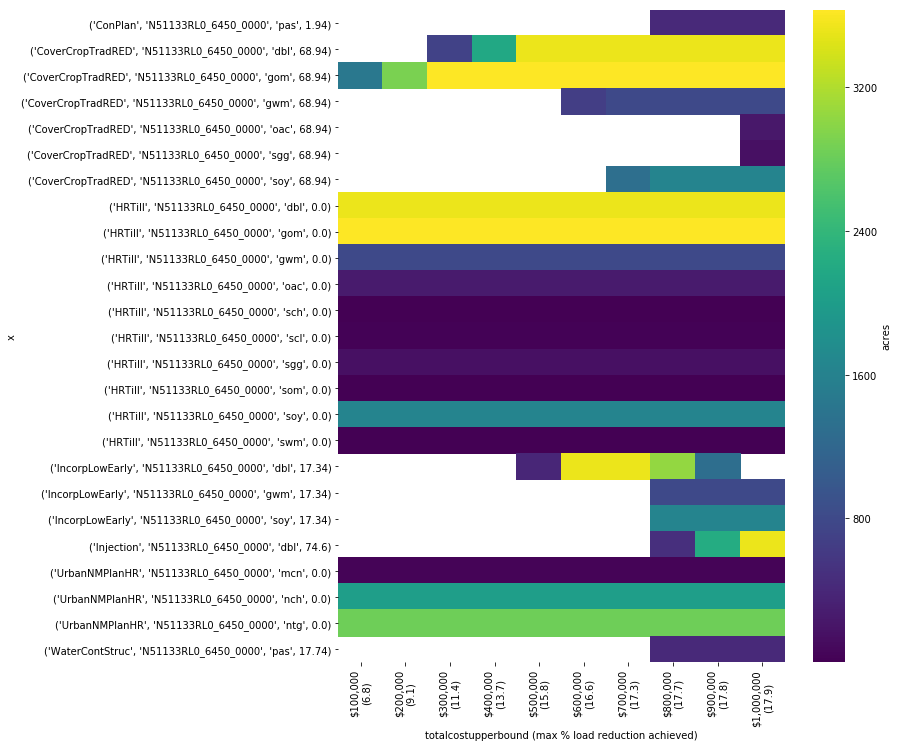

In [7]:
# Filepath to save to
filenamestr = ''.join(['output/loadobj_heatmap_costboundsequence_', 'ipopt', '_',
                           datetime.now().strftime('%Y-%m-%d_%H%M%S'), '.png'])
savefilepathandname = os.path.join(projectpath, filenamestr)

heatmap_loadobj(df=df_piv, savefilepathandname=savefilepathandname, xname='totalcostupperbound')

In [8]:
# function to return ordered unique values
def f5(seq, idfun=None): 
   # order preserving
   if idfun is None:
       def idfun(x): return x
   seen = {}
   result = []
   for item in seq:
       marker = idfun(item)
       # in old Python versions:
       # if seen.has_key(marker)
       # but in new ones:
       if marker in seen: continue
       seen[marker] = 1
       result.append(item)
   return result

combospresent = f5(zip(df.bmpshortname, df.loadsource))
unique_bmpnames = set(df.bmpshortname)
unique_lsnames = f5(df.loadsource)

nvarsperbmp = {b:None for b in unique_bmpnames}
for b in unique_bmpnames:
    nvarsperbmp[b] = len([x for x in combospresent if (x[0]==b)])
maxvarsofabmp = max(nvarsperbmp.values())
print(maxvarsofabmp)

sorted_keys = sorted(nvarsperbmp.items(), key=lambda x: x[1])
unique_bmpnames = list(x[0] for x in sorted_keys)
print(sorted_keys)


10
[('WaterContStruc', 1), ('ConPlan', 1), ('Injection', 1), ('IncorpLowEarly', 3), ('UrbanNMPlanHR', 3), ('CoverCropTradRED', 6), ('HRTill', 10)]


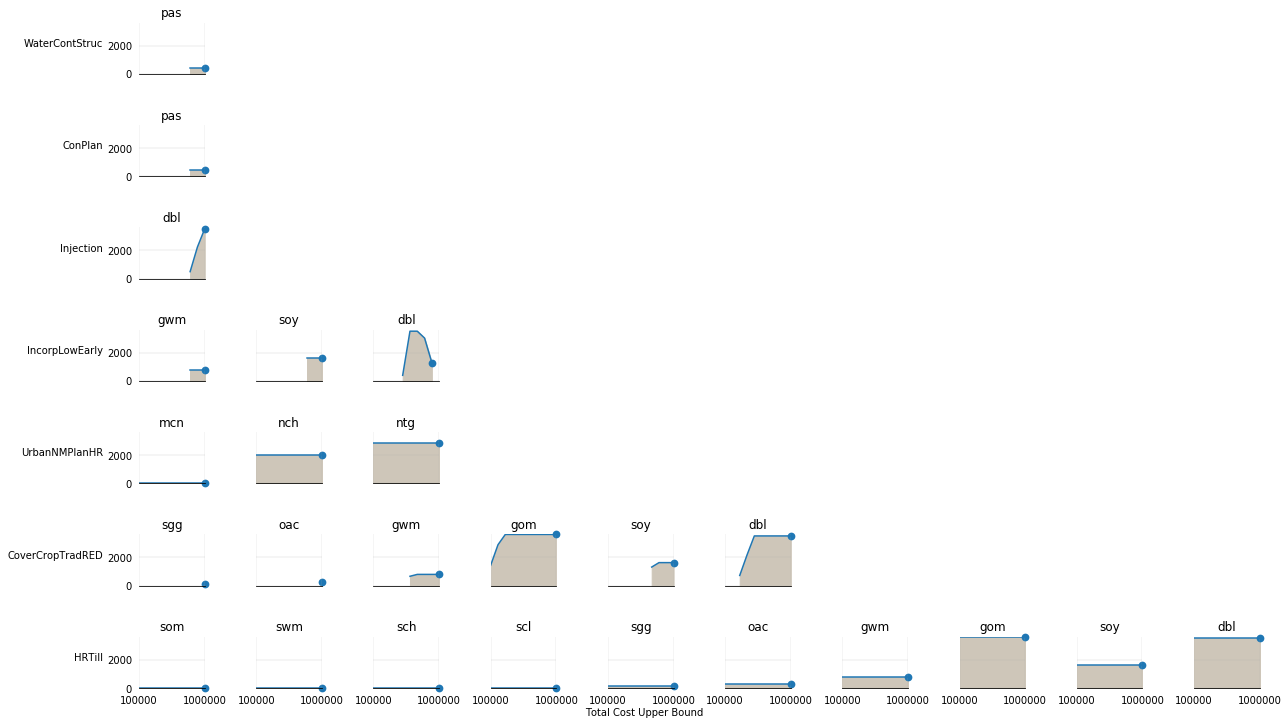

In [9]:
# We can ask for ALL THE AXES and put them into axes
fig, axes = plt.subplots(nrows=len(unique_bmpnames), ncols=maxvarsofabmp, sharex=True, sharey=True, figsize=(18,10))
axes_list = [item for sublist in axes for item in sublist] 


# ordered_var_names = df.groupby(by=['bmpshortname', 'loadsource'])['acres'].last().sort_values(ascending=False).index
        
from itertools import product
all_possibles = list(product(unique_bmpnames, unique_lsnames))
ordered_var_names = []
for posspair in all_possibles:
    if posspair in combospresent:
        ordered_var_names.append(posspair)

# Now instead of looping through the groupby
# you CREATE the groupby
# you LOOP through the ordered names
# and you use .get_group to get the right group
grouped = df.groupby(by=['bmpshortname', 'loadsource'])

first_x = df['totalcostupperbound'].min()
last_x = df['totalcostupperbound'].max()

max_acres = df['acres'].max()

i = {b:0 for b in unique_bmpnames}  # an empty dictionary of indices

for varname in ordered_var_names:
    selection = grouped.get_group(varname)

#     ax = axes_list.pop(0)
    bidx = unique_bmpnames.index(varname[0])
    ax = axes[bidx, i[varname[0]]]
    if i[varname[0]] == 0:
        ax.set_ylabel(varname[0], rotation=0, horizontalalignment='right')
    i[varname[0]] += 1
    axes_list.remove(ax)
    
    selection.plot(x='totalcostupperbound', y='acres', label=varname, ax=ax, legend=False)
    ax.fill_between(x=selection['totalcostupperbound'],y1=0,y2=selection['acres'],color='#cec6b9')
    ax.set_title(varname[1])
    ax.tick_params(
        which='both',
        bottom=False,
        left=False,
        right=False,
        top=False
    )
    ax.grid(linewidth=0.25)
    ax.set_xlim((first_x, last_x))
    ax.set_xlabel("")
    ax.set_xticks((first_x, last_x))
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    max_constraint = selection['totalcostupperbound'].max()
    acres_value = float(selection.loc[df['totalcostupperbound'] == max_constraint]['acres'])
    ax.set_ylim((0, max_acres))
    ax.scatter(x=[max_constraint], y=[acres_value], s=60, clip_on=False, linewidth=0)
#     ax.annotate(str(int(gdp_value / 1000)) + "k", xy=[max_year, gdp_value], xytext=[7, -2], textcoords='offset points')

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()
    
fig.text(0.5, 0.00, 'Total Cost Upper Bound', ha='center')
    
plt.tight_layout()
plt.subplots_adjust(hspace=1)

filenamestr = ''.join(['output/loadobj_smallmult_costboundsequence_', 'ipopt', '_',
                           datetime.now().strftime('%Y-%m-%d_%H%M%S'), '.png'])
savefilepathandname = os.path.join(projectpath, filenamestr)
plt.savefig(savefilepathandname)

In [10]:
# Heatmap for the gradient information (right now we're not saving that...)

fig = plt.figure(figsize=(10, 12))
ax = sns.heatmap(df_g_piv[df_g_piv.columns.difference(['totalcostupperbound', 'range', 'objective'])].transpose(),
                cmap='viridis',
                cbar_kws={'label': 'acres'},
                xticklabels=list( '%s\n(%.1f)' % ("${0:,.0f}".format(x),y)
                                 for x,y in
                                 zip(df_piv['totalcostupperbound'], round(df_piv['objective'],1))
                                )
                )
plt.xlabel("totalcostupperbound (max % load reduction achieved)")

# filenamestr = ''.join(['output/loadobj_Gheatmap_costboundsequence_', solvername, '_',
#                            datetime.now().strftime('%Y-%m-%d_%H%M%S'), '.png'])
# savefilepathandname = os.path.join(projectpath, filenamestr)
# plt.savefig(savefilepathandname, bbox_inches='tight')

NameError: name 'df_g_piv' is not defined

<Figure size 720x864 with 0 Axes>

In [ ]:
# Another plot that uses the gradient side-by-side with the acres

df_toplot = df_piv[df_piv.columns.difference(['totalcostupperbound', 'range', 'objective'])]
varnum = df_toplot.shape[1]

fig, axes = plt.subplots(varnum, 2, sharex=True, figsize=(9, 14))

for counter, columnname in enumerate(df_toplot):
    ax = axes[counter, 0]
    
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.grid(color='#D3D3D3', linestyle='-', linewidth=1)
    
    ax.plot(df_piv['totalcostupperbound'], df_piv[columnname].round(2))
    
    ax.set_ylabel(str(columnname), rotation=0, horizontalalignment='right')
    
df_toplot = df_g_piv[df_g_piv.columns.difference(['totalcostupperbound', 'range', 'objective'])]
varnum = df_toplot.shape[1]

maxv = np.nanmax(df_toplot.values)
for counter, columnname in enumerate(df_toplot):
    ax = axes[counter, 1]
    
    ax.set_ylim([0,maxv])
    
#     ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.grid(color='#D3D3D3', linestyle='-', linewidth=1)
    
    ax.plot(df_piv['totalcostupperbound'], df_g_piv[columnname])
    
#     ax.set_ylabel(str(columnname), rotation=0, horizontalalignment='right')